# Ворди.

## Что сделанно:
 - Обработали оцифровали обе таблицы за 2021 и 2022 года, согласно словарям. Соединили две таблицы в один датафрейм. И построили графики по сводным таблицам. 

In [54]:
# Импорт библиотек:
import pandas as pd
import numpy as np
import re

import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns

In [69]:
df_21 = pd.read_excel('2021.xlsx')
df_22 = pd.read_excel('2022.xlsx')

display(df_21.head(3))

Отметка времени  \
0 2021-04-25 20:08:38.212   
1 2021-05-25 09:39:55.299   
2 2021-05-27 09:54:29.263   

  1.1. Можно ли сказать, что в нашем регионе создана инклюзивное пространство (комфортная среда, позволяющая всем в равной степени получать и использовать блага цивилизации и услуг) для детей-инвалидов?  \
0       Нет, работа ведется, но результатов маловато                                                                                                                                                         
1         Нет, не делается ничего в этом направлении                                                                                                                                                         
2  Да, по крайней мере для этого много делается и...                                                                                                                                                         

  1.2. Можно ли сказать, что ваш ребенок имеет те же возможности (которыми он при желании может воспользоваться), что и здоровые дети?  \
0  Скорее нет, для этого приходится прилагать дос...                                                                                     
1                                     Да, однозначно                                                                                     
2  Скорее да, исключая некоторые варианты, но зде...                                                                                     

  1.3. Как Вы считаете, соблюдаются ли в полной мере социальные права и свободы настоящего и будущего для вашего ребенка? [Право на труд]  \
0                                                Нет                                                                                        
1                                   Не в полной мере                                                                                        
2                                   Не в полной мере                                                                                        

  1.3. Как Вы считаете, соблюдаются ли в полной мере социальные права и свободы настоящего и будущего для вашего ребенка? [Право на отдых]  \
0                                                Нет                                                                                         
1                                   Не в полной мере                                                                                         
2                                   Не в полной мере                                                                                         

  1.3. Как Вы считаете, соблюдаются ли в полной мере социальные права и свободы настоящего и будущего для вашего ребенка? [Право на социальное обеспечение]  \
0                                   Не в полной мере                                                                                                          
1                                   Не в полной мере                                                                                                          
2                                   Не в полной мере                                                                                                          

  1.3. Как Вы считаете, соблюдаются ли в полной мере социальные права и свободы настоящего и будущего для вашего ребенка? [Право на охрану и помощь семье]  \
0                                                Нет                                                                                                         
1                                   Не в полной мере                                                                                                         
2                                   Не в полной мере                                                                                                         

  1.3. Как Вы считаете, соблюдаются ли в полной мере социальные права и свободы настоящего и будущего для вашег

# Предобработка данных.

In [56]:
# Переименуем столбец '[Правовая помощь]' в 'Общественные организации[Правовая помощь]', он дублируется
# в обоих датафреймах, дублирующиеся столбцы не позволяют объединить таблицы, в дальнейшем объединим их с помощью - pd.concat
df_21 = df_21.rename(columns = {df_21.columns[336]:'Общественные организации[Правовая помощь]'})
df_22 = df_22.rename(columns = {df_22.columns[370]:'Общественные организации[Правовая помощь]'})

# Так же даляем дублирующиеся с толбцы с ненужной информацией:
df_22.drop(df_22.columns[[439,440]], axis = 1, inplace=True)

display(df_22.iloc[:2,368:371])

[Социальная помощь (по уходу за ребенком, присмотр)]  \
0        Не пользовался, но хотел бы воспользоваться      
1                      Не пользовался и не собираюсь      

                    [Помощь в трудоустройстве]  \
0  Не пользовался, но хотел бы воспользоваться   
1                Не пользовался и не собираюсь   

     Общественные организации[Правовая помощь]  
0  Не пользовался, но хотел бы воспользоваться  
1                Не пользовался и не собираюсь

In [57]:
## Создадим словари для замены текстовых значений на числовые:

# Примечание: ответы "затрудняюсь оценить", "Этого нет (не знаю) и это не нужно", "Не обращался, нет необходимости"
# - приравниваем к пропускам - np.nan.

dict1 = {'Да, однозначно':1,
         'Да, по крайней мере для этого много делается и результаты видны':0.5,
         'Нет, работа ведется, но результатов мало':0,
         'Нет, работа ведется, но результатов маловато':0,
         'Нет, не делается ничего в этом направлении':-1}

# Дублирующийся словарь к dict1, только для таблицы за 2022:
dict25 = {'Да, по крайней мере для этого много делается и результаты видны':0.5,
          'Нет, работа ведется, но результатов мало':0,
          'Нет, не делается ничего в этом направлении':-1,
          'Да, однозначно':1}

dict2 = {'Да, однозначно': 1,
         'Скорее да, исключая некоторые варианты, но здесь нет вины общества и государства': 0.5,
         'Скорее нет, для этого приходится прилагать достаточные усилия': -0.5,
         'Нет, он во всем ограничен': -1}

dict3 = {'Да': 1,
         'Не в полной мере': 0.5,
         'Нет': -1}

dict4 = {'Удовлетворен полностью':1,
         'Удовлетворен частично':0.5,
         'Затрудняюсь оценить':0,
         'Не удовлетворен':-1}
         
dict5 = {'Да, ранняя помощь была оказана лишь в полном объеме благодаря врачам':1,
         'Да, ранняя помощь была оказана в результате ваших собственных усилий':1,
         'Нет, ранняя помощь не была оказана в полном объеме':0.5,
         'Ранняя помощь не требовалась':0,
         'Нет, ранняя помощь вообще не была оказана':-1}

dict6 = {'Достаточно':1,
         'Необходимо больше':0.5,
         'Затрудняюсь оценить':np.nan,
         'Совершенно недостаточно':-1}

dict7 = {'Доступно':1,
         'Частично доступно':0.5,
         'Затрудняюсь оценить':np.nan,
         'Не доступно':-1}

dict8 = {'Регулярно':1,
         'Периодически':0.75,
         'Очень редко':0.5,
         'Никогда или практически никогда':-1}

dict9 = {'Да':1,
          'Разработала, но не своевременно':0.5,
          'Частично':0.5,
          'Затрудняюсь ответить':np.nan,
          'Нет':-1}

dict10 = {'Получает':1,
          'Получает, но объем помощи недостаточный':0.5,
          'Не получает':-1}

dict11 = {'Получаем в образовательной организации':1,
          'Получаем в государственной организации, предоставляющей услуги реабилитации/абилитации':1,
          'Получаем в ППМС-центре':1,
          'Получаем в негосударственной организации':1,
          'Нет, не получаем, не обращались':0,
          'Нет, не получаем, в связи с отказом':-1}

dict12 = {'Льготы есть и получаем все в полном объеме и своевременно':1,
          'Льготы есть, но получение связано с определенными проблемами (отсутствие лекарств, труднодоступность их получения, лекарства ненадлежащего качества или свойств и т.д.)':0.5,
          'Льгот нет, в медикаментозной поддержке ребенок не нуждается':0,
          'Льгот нет, покупаем лекарства за свой счет':-1,
          'Льготы есть, но получить по ним лекарства практически невозможно':-1}

dict13 = {'Нет трудностей':1,
          'Затрудняюсь оценить/не пользуюсь':np.nan,
          'Есть трудности':-1}

dict14 = {'Это есть и это необходимо':1,
          'Этого нет (не знаю), но это необходимо':0.5,
          'Затрудняюсь оценить':np.nan,
          'Этого нет (не знаю) и это не нужно':np.nan}

dict15 = {'Полностью владею информацией':1,
          'Необходима информация и консультация':0.5,
          'Информация не нужна':0}

dict16 = {'Пользовался и хотел бы воспользоваться еще':1,
          'Не пользовался, но хотел бы воспользоваться':0.5,
          'Не пользовался и не собираюсь':0,
          'Пользовался и больше не собираюсь':-1}

dict17 = {'Знаю и принимаю участие в работе':1,
         'Знаю':0.5,
         'Не слышал':0}

dict18 = {'Обращался и получал реальную помощь':1,
          'Слышал, но не обращался':0.5,
          'Не слышал':0}

dict19 = {'Да':1,
          'Нет':-1}

dict20 = {'Достаточно комфортными (удобными) для проживания с ребенком-инвалидом':1,
          'Пригодными (жилье обустроено под нужды ребенка) для проживания с ребенком-инвалидом':1,
          'Недостаточно пригодными (жилье недостаточно обустроено под Ваши нужды) для проживания с ребенком-инвалидом':0,
          'Не пригодными (нет того, что Вам крайне необходимо) для проживания с ребенком-инвалидом':-1}

dict21 = {'Высокий':1,
          'Средний':0.5,
          'Низкий':0}

dict22 = {'Семье хватает средств не только на необходимые траты, но и на большие покупки, комфортный отдых':1,
          'Семье хватает средств на необходимые траты, но на большие покупки и отдых приходится копить (брать кредит)':0.7,
          'Семье хватает средств на необходимые траты, связанные с питанием, одеждой, оплатой счетов и лечения':0.5,
          'Семье с трудом хватает средств на необходимые траты, связанные с питанием, одеждой, оплатой счетов и лечения':0.3,
          'Семье не хватает средств на необходимые траты, связанные с питанием, одеждой, оплатой счетов и лечения':0.1}
          
dict23 = {'Ребенок не ограничен в общении (характер заболевания это позволяет)':1,
          'Круг общения ребенка ограничен приходящими знакомыми, друзьями, родственниками':0.75,
          'Круг общения ребенка ограничен проживающими совместно с ним членами семьи':0.5,
          'Круг общения ребенка ограничен, в силу заболевания или характера ребенка':0}

dict24 = {'Получил помощь в полном объеме':1,
          'Получил помощь частично':0.5,
          'Не обращался, но помощь нужна':0.5,
          'Не обращался, нет необходимости':np.nan,
          'Не получил помощь':-1}

# Создаем список словарей:
list_dicts = (dict1, dict2, dict3, dict4, dict5, dict6, dict7, dict8, dict9,
              dict10, dict11, dict12, dict13, dict14, dict15, dict16, dict17,
              dict18, dict19, dict20, dict21, dict22, dict23, dict24, dict25)

In [58]:
# Оцифруем таблицу за 2021 (замена текстовых/категориальных значений на числа):

digit_21 = df_21.copy()

# Оцифруем таблицу за 2021г., используя словари:
# Для каждого столбца в таблице:
for col in range(digit_21.shape[1]):
    
    # Создадим список уникальных ответов пользователей:
    spisok = np.ndarray.tolist(digit_21.iloc[:,col].unique())
    
    # Удалим из нашего списка значения - np.nan, они мешают оцифровать таблицу:
    if np.nan in spisok:
        spisok.remove(np.nan)
        
    # И приведем тип каждого элемента списка к str, так как сравнить нужно идентичные списки:    
    spisok = str(spisok)
    
    # Для каждого словаря, созданного выше: 
    for i in list_dicts:
        
        # Проверим равны ли список уникальных ответов текущего столбца и словаря. И если списки равны:
        if (sorted(spisok) == sorted(str(list(i.keys())))) is True:
            
            # Делаем оцифровку столбца согласно словарю:
            digit_21.iloc[:,col] = digit_21.iloc[:,col].map(i)  
            
display(digit_21)

Отметка времени  \
0   2021-04-25 20:08:38.212   
1   2021-05-25 09:39:55.299   
2   2021-05-27 09:54:29.263   
3   2021-05-27 16:36:41.572   
4   2021-05-28 18:09:27.373   
..                      ...   
992 2021-06-04 23:32:01.288   
993 2021-04-28 16:21:19.345   
994 2021-05-20 20:53:42.253   
995 2021-05-27 11:31:17.577   
996 2021-06-02 01:24:44.054   

     1.1. Можно ли сказать, что в нашем регионе создана инклюзивное пространство (комфортная среда, позволяющая всем в равной степени получать и использовать блага цивилизации и услуг) для детей-инвалидов?  \
0                                                  0.0                                                                                                                                                          
1                                                 -1.0                                                                                                                                                          
2                                                  0.5                                                                                                                                                          
3                                                  1.0                                                                                                                                                          
4                                                  0.5                                                                                                                                                          
..                                                 ...                                                                                                                                                          
992                                                0.5                                                                                                                                                          
993                                                0.0                                                                                                                                                          
994                                                0.0                                                                                                                                                          
995                                                0.5                                                                                                                                                          
996                                                0.5                                                                                                                                                          

     1.2. Можно ли сказать, что ваш ребенок имеет те же возможности (которыми он при желании может воспользоваться), что и здоровые дети?  \
0                                                 -0.5                                                                                      
1                                                  1.0                                                                                      
2                                                  0.5                                                                                      
3                                                  1.0                                                                                      
4                                                  0.5                                                                                      
..                                                 ...                                                                                      
992                                                0.5                                                                                      
99

In [59]:
# Так же оцифруем таблицу за 2022 подобным способом:
digit_22 = df_22.copy()

for col in range(digit_22.shape[1]):
    spisok = np.ndarray.tolist(digit_22.iloc[:,col].unique()) 
    if np.nan in spisok:
        spisok.remove(np.nan)  
    spisok = str(spisok) 
    for i in list_dicts:
        if (sorted(spisok) == sorted(str(list(i.keys())))) is True:
            digit_22.iloc[:,col] = digit_22.iloc[:,col].map(i)  
            
display(digit_22)

Отметка времени  \
0    2022-04-09 14:42:26.110   
1    2022-04-12 12:06:58.107   
2    2022-04-12 14:43:08.689   
3    2022-04-12 20:21:23.988   
4    2022-04-14 15:18:06.098   
...                      ...   
1106 2022-06-21 17:02:59.328   
1107 2022-06-22 12:01:31.644   
1108 2022-06-29 23:10:17.808   
1109 2022-06-29 23:11:39.714   
1110 2022-06-30 10:45:22.465   

      1.1. Можно ли сказать, что в нашем регионе создана инклюзивное пространство (комфортная среда, позволяющая всем в равной степени получать и использовать блага цивилизации и услуг) для детей-инвалидов?  \
0                                                   0.5                                                                                                                                                          
1                                                   0.5                                                                                                                                                          
2                                                   0.0                                                                                                                                                          
3                                                   0.5                                                                                                                                                          
4                                                   0.0                                                                                                                                                          
...                                                 ...                                                                                                                                                          
1106                                                0.5                                                                                                                                                          
1107                                                1.0                                                                                                                                                          
1108                                                0.0                                                                                                                                                          
1109                                                0.0                                                                                                                                                          
1110                                                0.5                                                                                                                                                          

      1.2. Можно ли сказать, что ваш ребенок имеет те же возможности (которыми он при желании может воспользоваться), что и здоровые дети?  \
0                                                   0.5                                                                                      
1                                                   0.5                                                                                      
2                                                  -0.5                                                                                      
3                                                   0.5                                                                                      
4                                                  -0.5                                                                                      
...                                                 ...                                                                                      
1106                                                1.0                                                          

# Посчитаем средние значения по разделам:

In [60]:
# Обработка имен столбцов таблиц(удалим из названий столбцов числа и точки, для правильного соедининения таблиц по столбцам):
digit_21.columns = digit_21.columns.map(lambda x: re.sub('[0-9.]', '', x))
digit_22.columns = digit_22.columns.map(lambda x: re.sub('[0-9.]', '', x))

In [61]:
# Соединим таблицы за 2021 и 2022. Укажем join='inner', чтобы в итоговую таблицу попали столбцы только с одинаковыми именами:
concat_df = pd.concat([digit_21, digit_22], join='inner')

concat_df

Отметка времени  \
0    2021-04-25 20:08:38.212   
1    2021-05-25 09:39:55.299   
2    2021-05-27 09:54:29.263   
3    2021-05-27 16:36:41.572   
4    2021-05-28 18:09:27.373   
...                      ...   
1106 2022-06-21 17:02:59.328   
1107 2022-06-22 12:01:31.644   
1108 2022-06-29 23:10:17.808   
1109 2022-06-29 23:11:39.714   
1110 2022-06-30 10:45:22.465   

       Можно ли сказать, что в нашем регионе создана инклюзивное пространство (комфортная среда, позволяющая всем в равной степени получать и использовать блага цивилизации и услуг) для детей-инвалидов?  \
0                                                   0.0                                                                                                                                                      
1                                                  -1.0                                                                                                                                                      
2                                                   0.5                                                                                                                                                      
3                                                   1.0                                                                                                                                                      
4                                                   0.5                                                                                                                                                      
...                                                 ...                                                                                                                                                      
1106                                                0.5                                                                                                                                                      
1107                                                1.0                                                                                                                                                      
1108                                                0.0                                                                                                                                                      
1109                                                0.0                                                                                                                                                      
1110                                                0.5                                                                                                                                                      

       Можно ли сказать, что ваш ребенок имеет те же возможности (которыми он при желании может воспользоваться), что и здоровые дети?  \
0                                                  -0.5                                                                                  
1                                                   1.0                                                                                  
2                                                   0.5                                                                                  
3                                                   1.0                                                                                  
4                                                   0.5                                                                                  
...                                                 ...                                                                                  
1106                                                1.0                                                                                  
1107                                               

In [62]:
# Добавим в таблицу средние значения по разделам:

# Функция получает диапазон номеров столбцов по разделу, рассчитывает среднее значение и добавляет новый столбец к датафрейму:
def average_for_partition(column_name, first_col, last_col):
    concat_df[column_name] = round(concat_df.iloc[:,first_col:last_col].mean(axis=1, numeric_only = True), 3)

# Расчитаем среднее по всем разделам, вызвав функцию выше:
average_for_partition('Раздел_Общая_оценка', 3, 47)
average_for_partition('Раздел_ранняя_помощь', 55, 67)
average_for_partition('Раздел_Психолого-медико-педагогическая_комиссия', 68, 80)
average_for_partition('Раздел_Образование', 81, 109)
average_for_partition('Раздел_Медико-социальная экспертиза', 110, 122)
average_for_partition('Раздел_Технические средства реабилитации', 123, 136)
average_for_partition('Раздел_Санаторно-курортное обеспечение', 136, 148)
average_for_partition('Раздел_Физкультура и спорт', 149, 163)
average_for_partition('Раздел_Здравоохранение', 164, 191)
average_for_partition('Раздел_Реабилитация', 192, 204)
average_for_partition('Раздел_Трудоустройство', 205, 221)
average_for_partition('Раздел_Сопровождаемое проживание', 222, 232)
average_for_partition('Раздел_Социально-психологическая и правовая помощь', 233, 259)
average_for_partition('Раздел_Социальная поддержка', 260, 272)
average_for_partition('Раздел_Паллиативная помощь', 273, 285)
average_for_partition('Раздел_Материальная помощь', 286, 298)
average_for_partition('Раздел_Доступная среда', 299, 313)
average_for_partition('Раздел_Общественные организации и проекты', 314, 344)
average_for_partition('Раздел_Социологический портрет', 345, 403)

concat_df

C:\Users\77033\AppData\Local\Temp\ipykernel_6060\3418085804.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  concat_df[column_name] = round(concat_df.iloc[:,first_col:last_col].mean(axis=1, numeric_only = True), 3)
C:\Users\77033\AppData\Local\Temp\ipykernel_6060\3418085804.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  concat_df[column_name] = round(concat_df.iloc[:,first_col:last_col].mean(axis=1, numeric_only = True), 3)
C:\Users\77033\AppData\Local\Temp\ipykernel_6060\3418085804.py:5: PerformanceWarning: DataFrame is

Отметка времени  \
0    2021-04-25 20:08:38.212   
1    2021-05-25 09:39:55.299   
2    2021-05-27 09:54:29.263   
3    2021-05-27 16:36:41.572   
4    2021-05-28 18:09:27.373   
...                      ...   
1106 2022-06-21 17:02:59.328   
1107 2022-06-22 12:01:31.644   
1108 2022-06-29 23:10:17.808   
1109 2022-06-29 23:11:39.714   
1110 2022-06-30 10:45:22.465   

       Можно ли сказать, что в нашем регионе создана инклюзивное пространство (комфортная среда, позволяющая всем в равной степени получать и использовать блага цивилизации и услуг) для детей-инвалидов?  \
0                                                   0.0                                                                                                                                                      
1                                                  -1.0                                                                                                                                                      
2                                                   0.5                                                                                                                                                      
3                                                   1.0                                                                                                                                                      
4                                                   0.5                                                                                                                                                      
...                                                 ...                                                                                                                                                      
1106                                                0.5                                                                                                                                                      
1107                                                1.0                                                                                                                                                      
1108                                                0.0                                                                                                                                                      
1109                                                0.0                                                                                                                                                      
1110                                                0.5                                                                                                                                                      

       Можно ли сказать, что ваш ребенок имеет те же возможности (которыми он при желании может воспользоваться), что и здоровые дети?  \
0                                                  -0.5                                                                                  
1                                                   1.0                                                                                  
2                                                   0.5                                                                                  
3                                                   1.0                                                                                  
4                                                   0.5                                                                                  
...                                                 ...                                                                                  
1106                                                1.0                                                                                  
1107                                               

In [63]:
# Создадим список имен итоговых колонок с вычисленными средними значениями по разделу,
#потребуется для создания сводных таблиц ниже и построения графиков:
mean_columns = ['Раздел_Общая_оценка',
                'Раздел_ранняя_помощь',
                'Раздел_Психолого-медико-педагогическая_комиссия',
                'Раздел_Образование',
                'Раздел_Медико-социальная экспертиза',
                'Раздел_Технические средства реабилитации',
                'Раздел_Санаторно-курортное обеспечение',
                'Раздел_Физкультура и спорт',
                'Раздел_Здравоохранение',
                'Раздел_Реабилитация',
                'Раздел_Трудоустройство',
                'Раздел_Сопровождаемое проживание',
                'Раздел_Социально-психологическая и правовая помощь',
                'Раздел_Социальная поддержка',
                'Раздел_Паллиативная помощь',
                'Раздел_Материальная помощь',
                'Раздел_Доступная среда',
                'Раздел_Общественные организации и проекты',
                'Раздел_Социологический портрет']

# Добавим столбец года:
concat_df['date_years'] = concat_df['Отметка времени'].dt.year

C:\Users\77033\AppData\Local\Temp\ipykernel_6060\2649403766.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  concat_df['date_years'] = concat_df['Отметка времени'].dt.year


Укажите, пожалуйста, возраст ребенка-инвалида  date_years  \
0                                         0-1 год        2021   
1                                         0-1 год        2022   
2                                        1-3 года        2021   
3                                        1-3 года        2022   
4                                       11-15 лет        2021   
5                                       11-15 лет        2022   
6                                       16-18 лет        2021   
7                                       16-18 лет        2022   
8                                         4-6 лет        2021   
9                                         4-6 лет        2022   
10                                       7-10 лет        2021   
11                                       7-10 лет        2022   
12                                  Старше 18 лет        2021   
13                                  Старше 18 лет        2022   

    Раздел_Доступная среда  Раздел_Здравоохранение  \
0                 0.375000                0.250000   
1                -0.312000                0.387176   
2                -0.259649                0.301622   
3                -0.622490                0.364404   
4                -0.280695                0.279312   
5                -0.307832                0.404835   
6                -0.398284                0.247535   
7                -0.198234                0.438087   
8                -0.304128                0.288684   
9                -0.353872                0.319181   
10               -0.325789                0.252463   
11               -0.224584                0.361526   
12               -0.311147                0.102853   
13               -0.270732                0.458528   

    Раздел_Материальная помощь  Раздел_Медико-социальная экспертиза  \
0                     0.781250                             0.833333   
1                     0.506579                             0.812500   
2                     0.433568                             0.600833   
3                     0.571429                             0.769182   
4                     0.417151                             0.576778   
5                     0.517734                             0.709906   
6                     0.399770                             0.589492   
7                     0.536787                             0.670900   
8                     0.429235                             0.591739   
9                     0.473573                             0.657101   
10                    0.380287                             0.550473   
11                    0.497391                             0.642172   
12                    0.261029                             0.653074   
13                    0.649390                             0.617429   

    Раздел_Образование  Раздел_Общая_оценка  \
0             0.899000             0.818250   
1             0.113105             0.553684   
2            -0.021973             0.337595   
3            -0.329224             0.508714   
4             0.470311             0.438787   
5             0.464971             0.547173   
6             0.399189             0.392851   
7             0.513191             0.649128   
8             0.247922             0.434296   
9             0.111171             0.506585   
10            0.435378             0.434130   
11            0.446908             0.542144   
12            0.122441             0.251324   
13            0.329341             0.575439   

    Раздел_Общественные организации и проекты  Раздел_Паллиативная помощь  \
0                                    0.265500                    0.866000   
1                                    0.047421                   -0.288158   
2                                    0.144189                    0.265324   
3                                   -0.094204                   -0.160061   
4                                    0.141402               

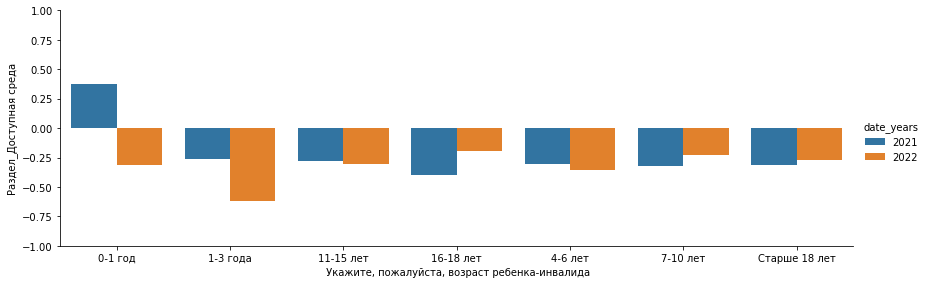

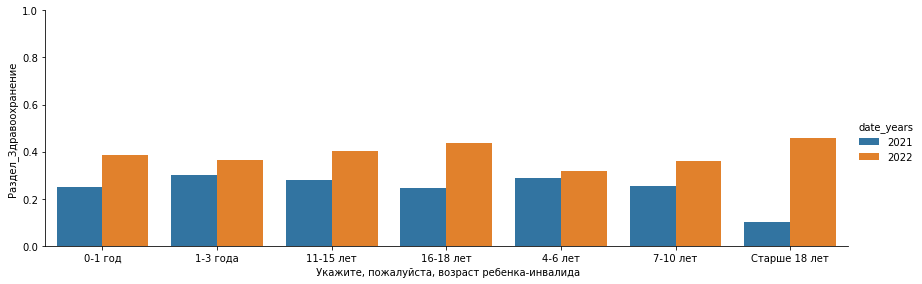

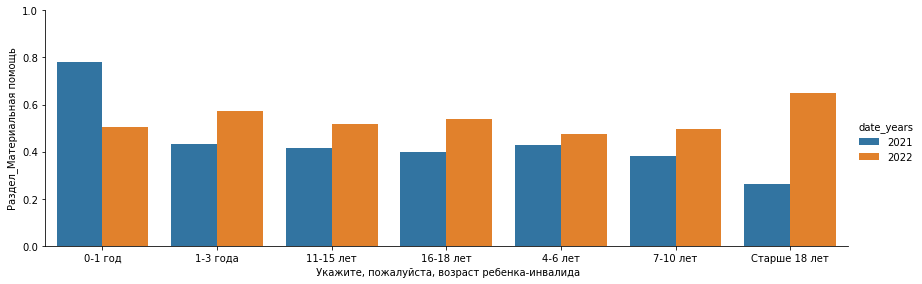

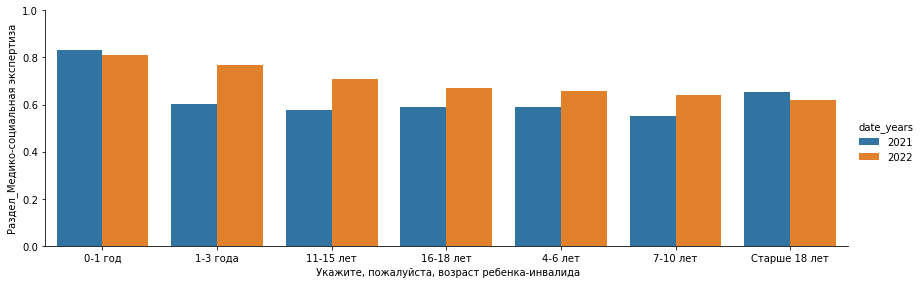

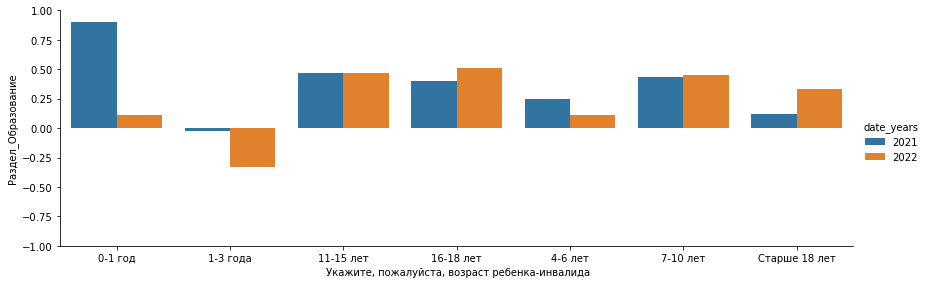

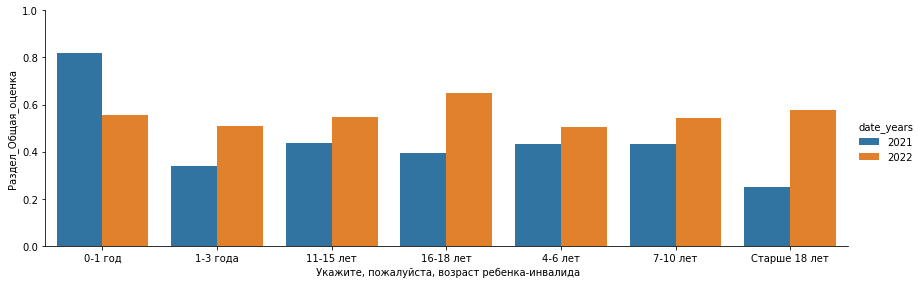

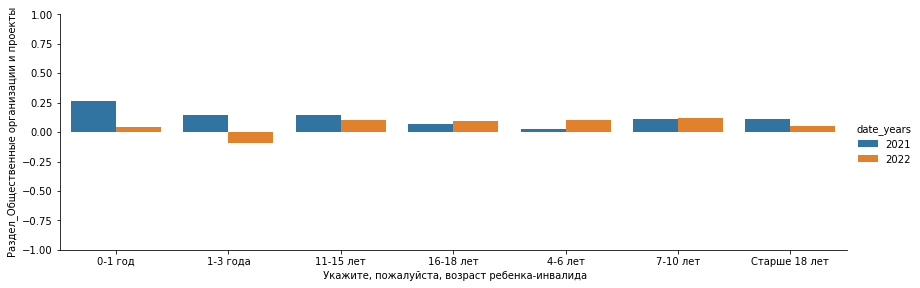

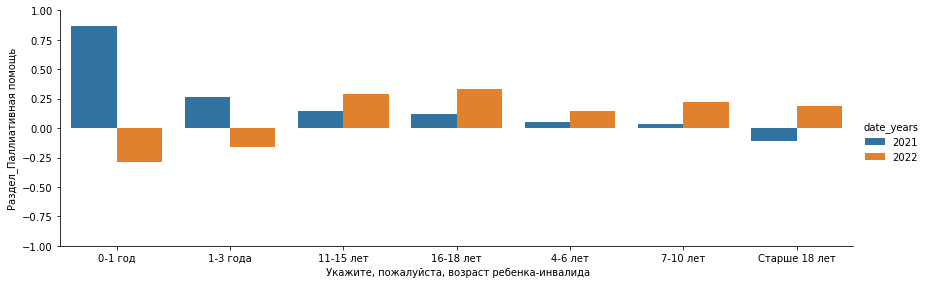

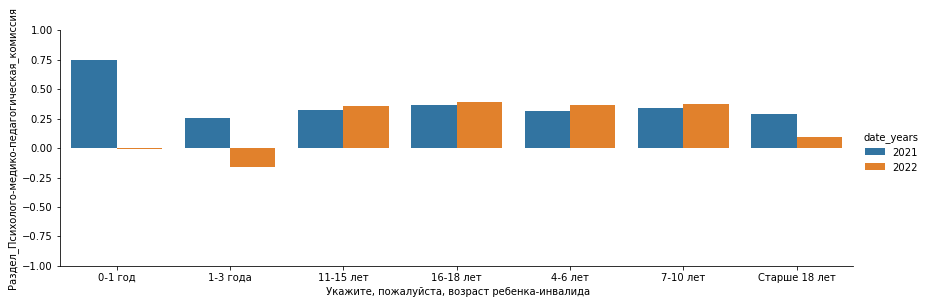

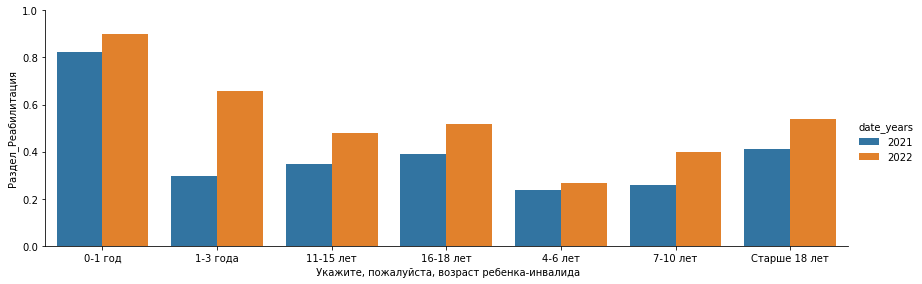

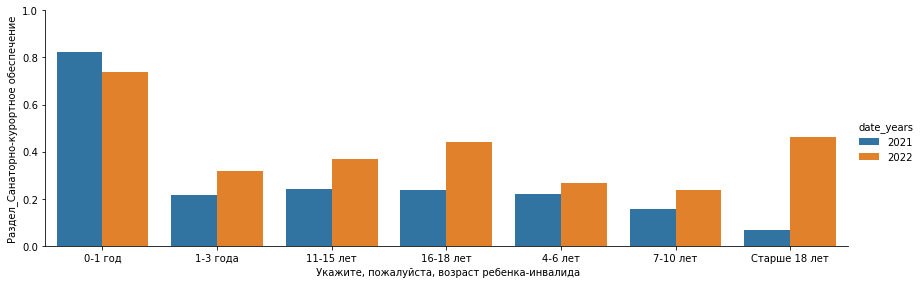

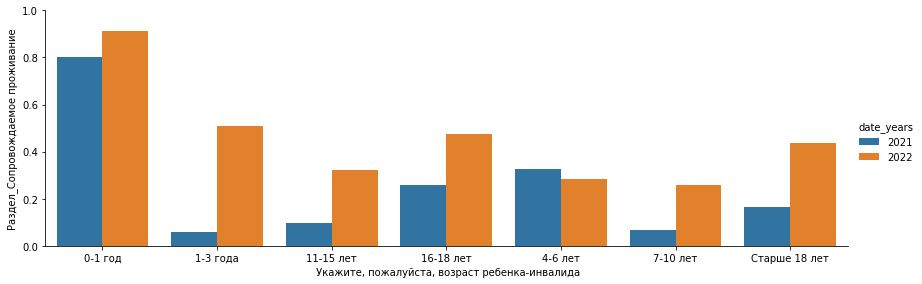

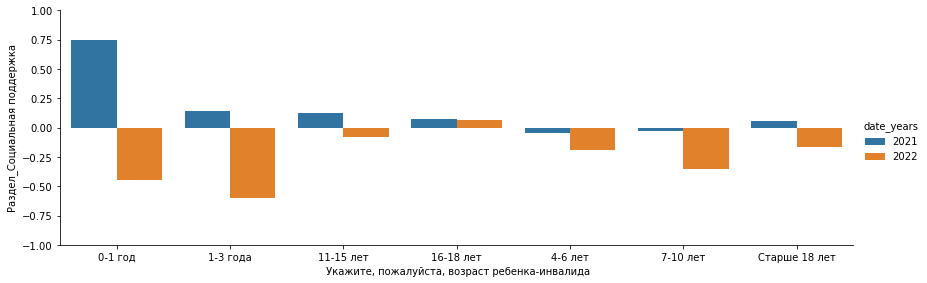

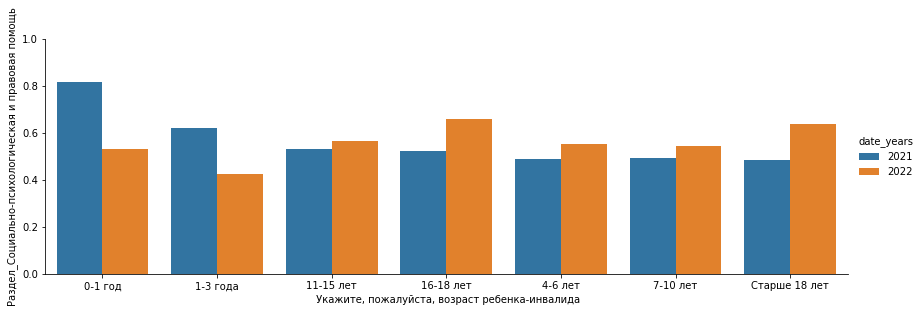

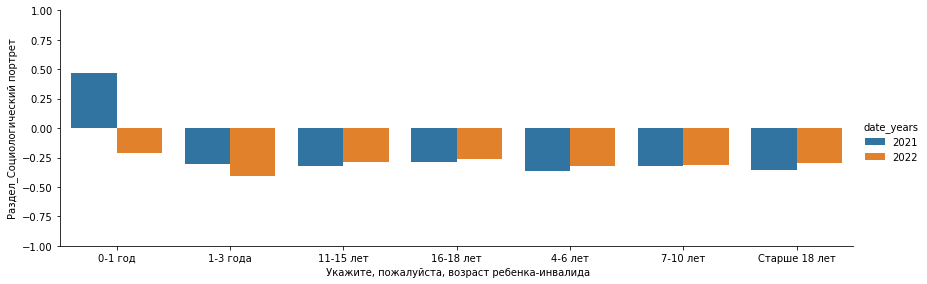

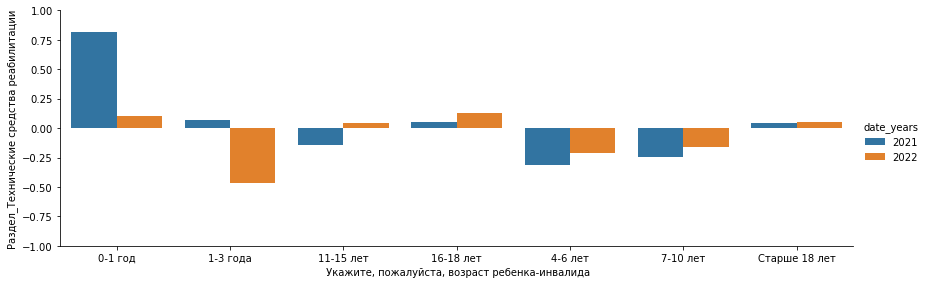

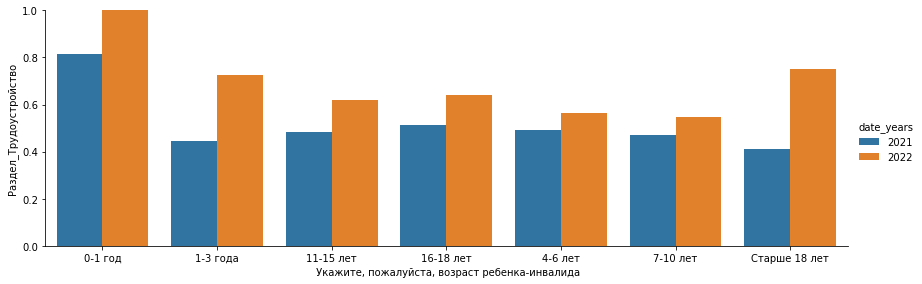

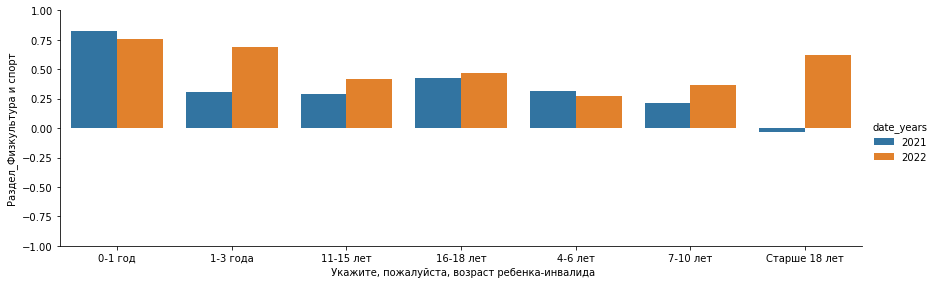

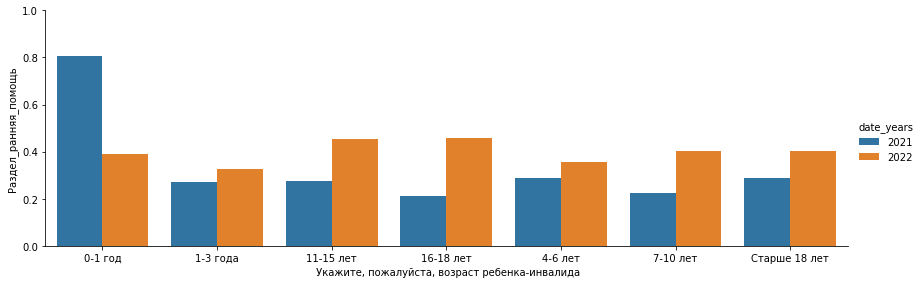

In [64]:
# Создадим сводную таблицу в разрезе возраста детей:
parameter = ' Укажите, пожалуйста, возраст ребенка-инвалида'

pivot_df = concat_df.pivot_table(index=[parameter,'date_years'],
                                 values=mean_columns, aggfunc='mean').reset_index()

display(pivot_df)

# Строим графики:
# Функция создания графика столбчатых диаграмм:
def plot_for_part(col, parameter, bottom_line):
    g = sns.catplot(data = pivot_df, x=parameter, y=col, hue='date_years', kind='bar',
           height=4, aspect=3,)
    g.set(ylim=(bottom_line, 1))
    
    plt.show()

# Отобразим графики по всем разделам в разрезе возраста:
# Вызовем функцию отрисовки графика для каждого раздела(диапазон границ отображения графиков меняется в зависимости
# от средних значений если есть отрицательные, то границы меняются с 0...1 до -1...1):
for i in pivot_df.columns[2:]:
    for j in pivot_df[i]:
        if j < 0:
            bottom_line = -1
            break
        else: bottom_line = 0    
    plot_for_part(i, parameter, bottom_line)

In [67]:
concat_df.loc[:,' Укажите, пожалуйста, территорию своего проживания:'].unique()

array(['Белгород', 'Валуйский район', 'Новооскольский район',
       'Ракитянский район', 'Яковлевский район', 'Старооскольский район',
       'Белгородский район', 'Губкинский городской округ',
       'Ровеньской район', 'Алексеевский район',
       'Красногвардейский район', 'Шебекинский район',
       'Корочанский район', 'Прохоровский район', 'Волоконовский район',
       'Грайворонский район', 'Краснояружский район',
       'Вейделевский район', 'Борисовский район', 'Красненский район',
       'Ивнянский район', 'Чернянский район'], dtype=object)

Укажите, пожалуйста, территорию своего проживания:  date_years  \
0                                  Алексеевский район         2021   
1                                  Алексеевский район         2022   
2                                            Белгород         2021   
3                                            Белгород         2022   
4                                  Белгородский район         2021   
5                                  Белгородский район         2022   
6                                   Борисовский район         2021   
7                                   Борисовский район         2022   
8                                     Валуйский район         2021   
9                                     Валуйский район         2022   
10                                 Вейделевский район         2021   
11                                 Вейделевский район         2022   
12                                Волоконовский район         2021   
13                                Волоконовский район         2022   
14                                Грайворонский район         2021   
15                                Грайворонский район         2022   
16                         Губкинский городской округ         2021   
17                         Губкинский городской округ         2022   
18                                    Ивнянский район         2021   
19                                    Ивнянский район         2022   
20                                  Корочанский район         2021   
21                                  Корочанский район         2022   
22                                  Красненский район         2021   
23                                  Красненский район         2022   
24                            Красногвардейский район         2021   
25                            Красногвардейский район         2022   
26                               Краснояружский район         2021   
27                               Краснояружский район         2022   
28                               Новооскольский район         2021   
29                               Новооскольский район         2022   
30                                 Прохоровский район         2021   
31                                 Прохоровский район         2022   
32                                  Ракитянский район         2021   
33                                  Ракитянский район         2022   
34                                   Ровеньской район         2021   
35                                   Ровеньской район         2022   
36                              Старооскольский район         2021   
37                              Старооскольский район         2022   
38                                   Чернянский район         2021   
39                                   Чернянский район         2022   
40                                  Шебекинский район         2021   
41                                  Шебекинский район         2022   
42                                  Яковлевский район         2021   
43                                  Яковлевский район         2022   

    Раздел_Доступная среда  Раздел_Здравоохранение  \
0                -0.428500                0.165500   
1                -0.156522                0.420311   
2                -0.298215                0.230812   
3                -0.334920                0.355360   
4                -0.301122                0.228326   
5                -0.326389                0.349923   
6                -0.560000                0.056417   
7                -0.324115                0.213385   
8                -0.613204                0.447904   
9                -0.013133                0.267233   
10               -0.310385                0.142692   
11                0.160111                0.480630   
12               -0.127731                0.584192   
13               -0.297235                0.323182   
14               -0.204154                0

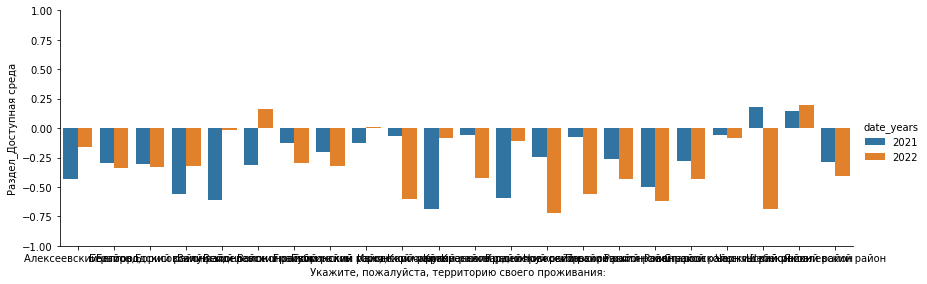

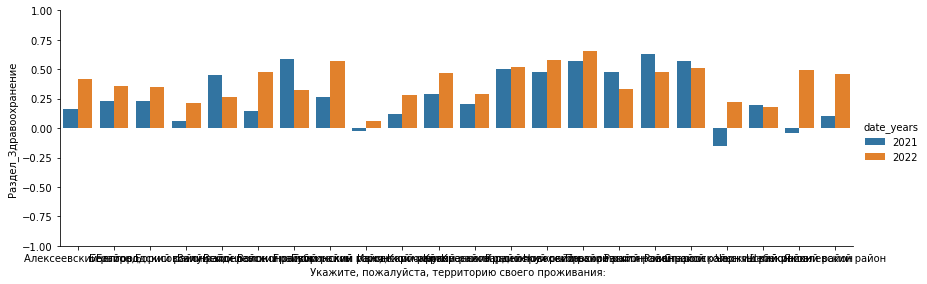

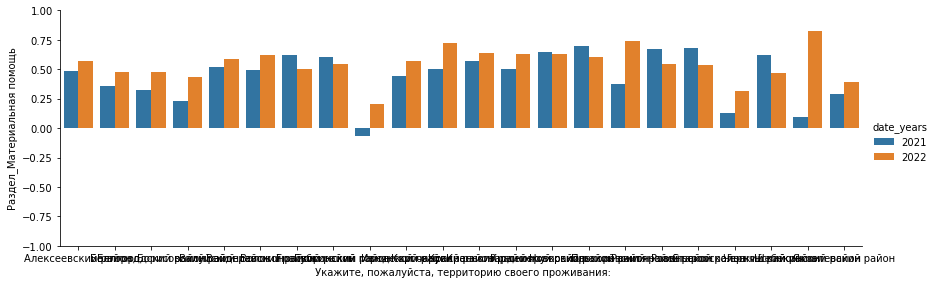

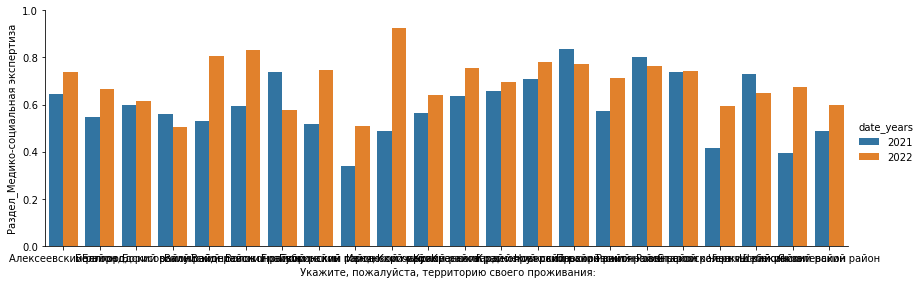

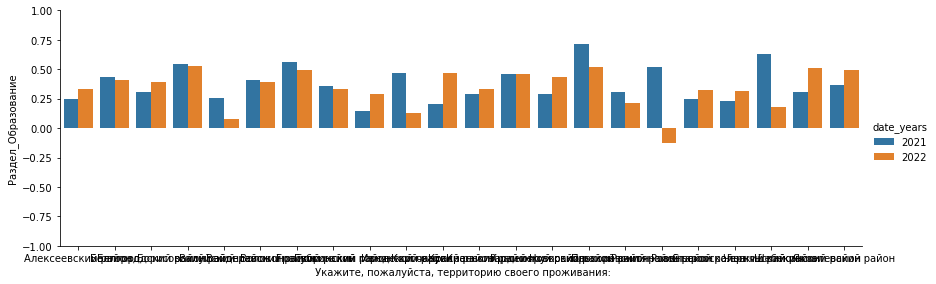

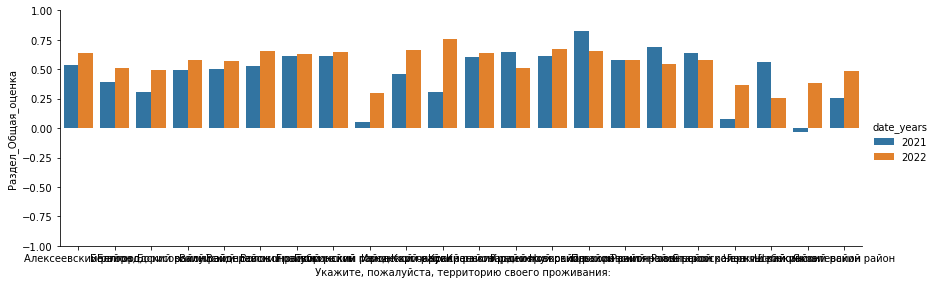

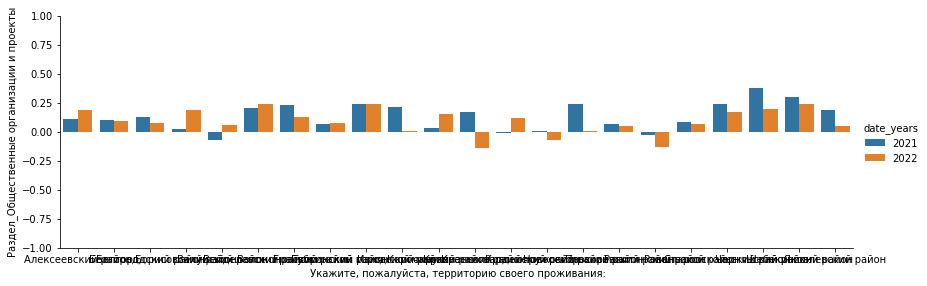

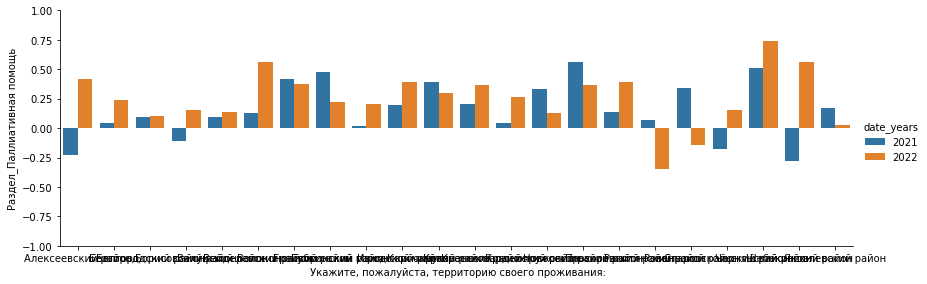

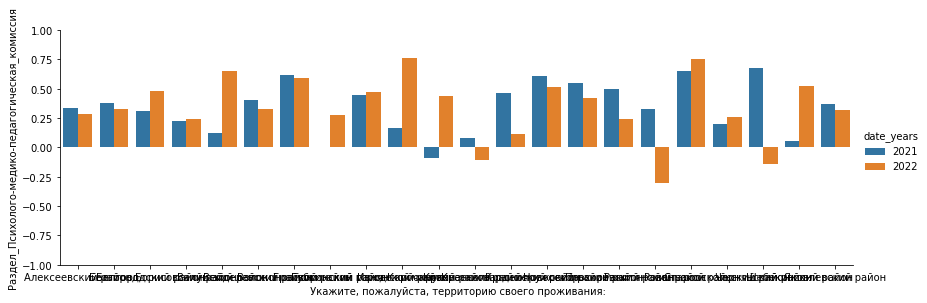

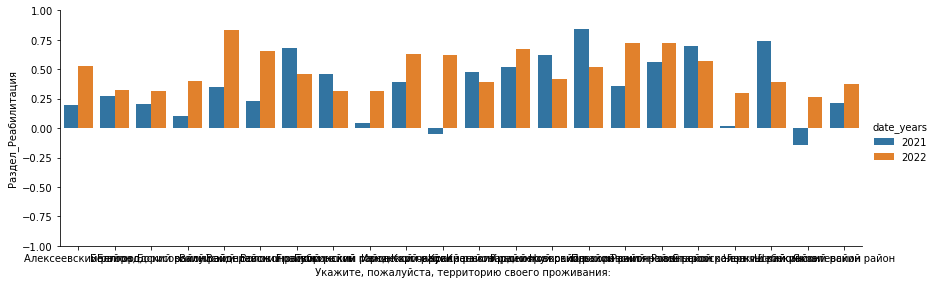

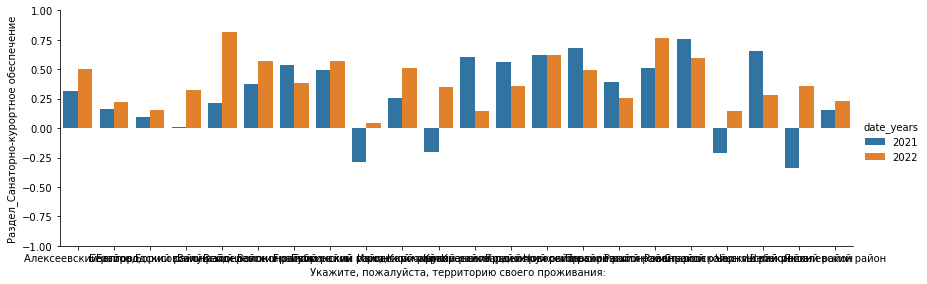

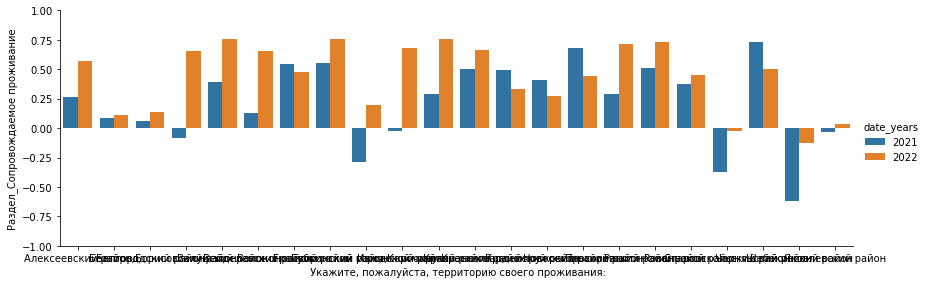

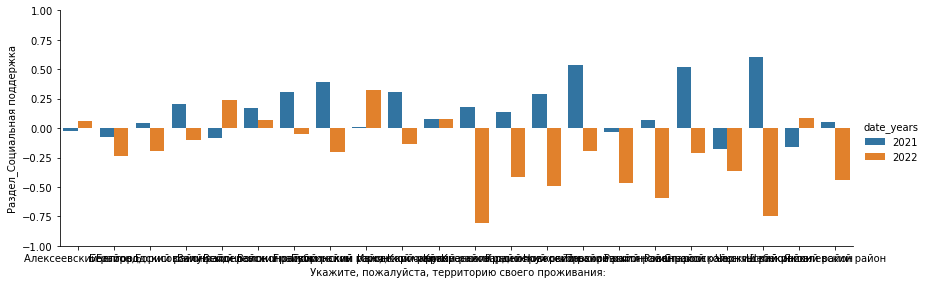

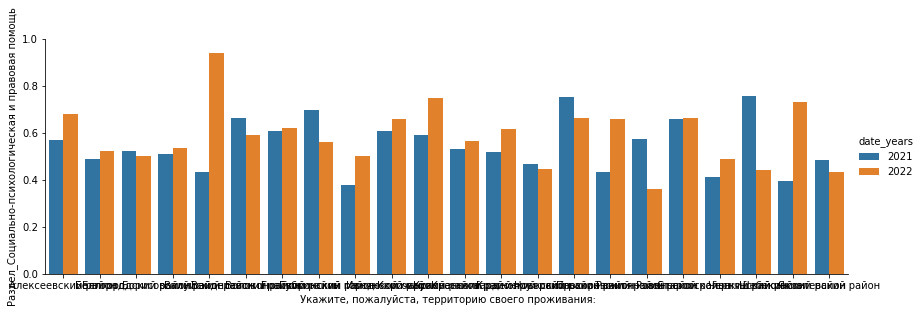

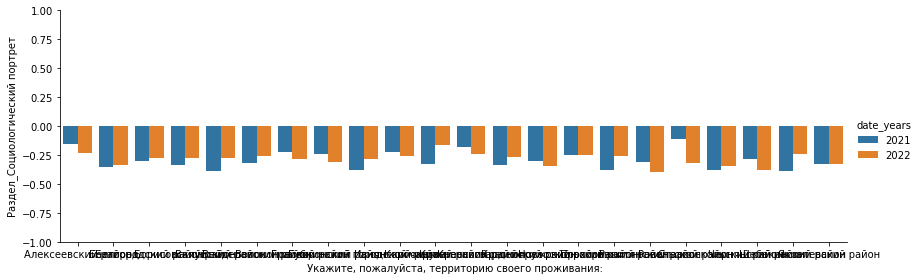

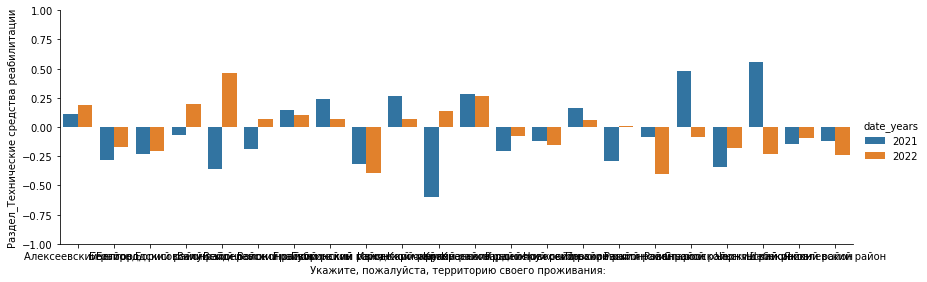

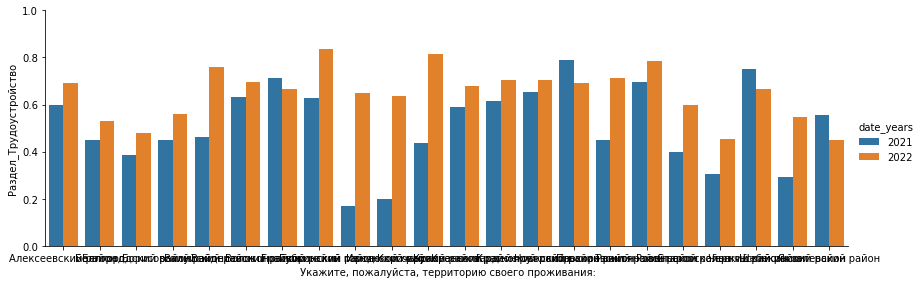

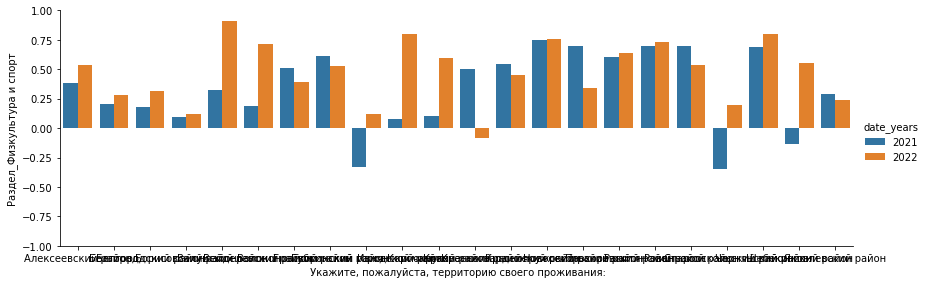

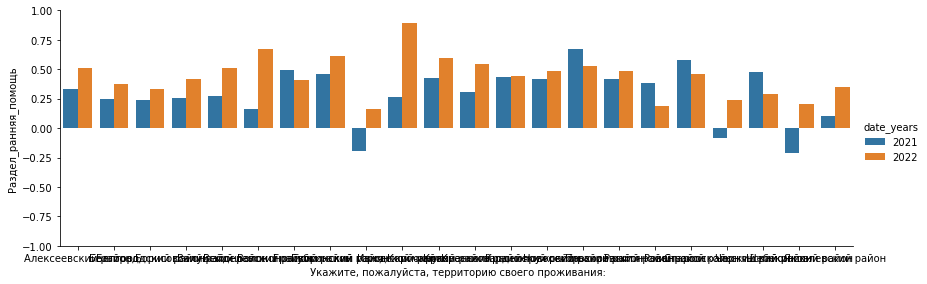

In [65]:
# Создадим сводную таблицу в разрезе места проживания:

parameter = ' Укажите, пожалуйста, территорию своего проживания:'

pivot_df = concat_df.pivot_table(index=[parameter,'date_years'],
                                 values=mean_columns, aggfunc='mean').reset_index()

display(pivot_df)

# Строим графики:
# Функция создания графика столбчатых диаграмм:
def plot_for_part(col, parameter, bottom_line):
    g = sns.catplot(data = pivot_df, x=parameter, y=col, hue='date_years', kind='bar',
           height=4, aspect=3,)
    g.set(ylim=(bottom_line, 1))
    
    plt.show()

# Отобразим графики по всем разделам в разрезе возраста:
# Вызовем функцию отрисовки графика для каждого раздела(диапазон границ отображения графиков меняется в зависимости
# от средних значений если есть отрицательные, то границы меняются с 0...1 до -1...1):
for i in pivot_df.columns[2:]:
    for j in pivot_df[i]:
        if j < 0:
            bottom_line = -1
            break
        else: bottom_line = 0    
    plot_for_part(i, parameter, bottom_line)

# Наработки, черновики и др............можно не проверять

In [ ]:
# Группировка по месту проживания:

ar = digit_21.iloc[:,345].value_counts().reset_index()

#ar = (ar.iloc[:,1].sum(axis=0))

gr = digit_21.groupby('19.1. Укажите, пожалуйста, возраст ребенка-инвалида.')[['Раздел_Социальная поддержка','Раздел_Паллиативная помощь']].mean()


def highlight(gr, col2highlite=i):
    ret = pd.DataFrame("", index=gr.index, columns=gr.columns)
    ret.loc[gr[i] < 0, col2highlite] = "background-color: red"
    ret.loc[gr[i] > 0, col2highlite] = "background-color: green"
    ret.loc[gr[i] == 0, col2highlite] = "background-color: yellow"
    return ret

cols = ['Раздел_Социальная поддержка','Раздел_Паллиативная помощь']
i = 'Раздел_Паллиативная помощь'

#for i in (cols):
gr.style.apply(highlight, col2highlite=i, axis=None)

# Найдем коэффициенты значимости разделов для опрашиваемых:

In [ ]:
# По разделу - Ранняя помощь:
ran_pom = pd.DataFrame(df_21['2.1. Была ли оказана ранняя помощь для Вашего ребенка в постановке диагноза и лечения'].value_counts(dropna=False).reset_index())
display(ran_pom)

# Разделим число опрошенных для которых первая помощь не нужна на общее колчество опрошенных, вычтем из 1 и получим коэффициент востребованности
ran_pom_koef = 1 - round(ran_pom.iloc[3,1] / len(d), 3)
ran_pom_koef

In [ ]:
# По разделу - Психолого-медико-педагогическая комиссия:
ran_pom = pd.DataFrame(df_21['3.2. Если Вы не пользовались услугами психолого-медико-педагогической комиссии для Вашего ребенка, в чем причина?'].value_counts(dropna=False).reset_index())
display(ran_pom)

# Разделим число опрошенных для которых в услуге пмпк нет необходимости на общее колчество опрошенных, вычтем из 1 и получим коэффициент востребованности
ran_pom_koef = round(1 - (ran_pom.iloc[1,1] / len(d)), 3)
ran_pom_koef

#### Вывод по разделу:

По разделу образования расчет коэфициента не требуется.


In [ ]:
#
# Разделы (номера столбцов):

# 1 0-54 Общая оценка
# 2 55-67 Ранняя помощь
# 3 68-80 Психолого-медико-педагогическая комиссия
# 4 81-109 Образование
# 5 110-122 Медико-социальная экспертиза
# 6 123-136 Технические средства реабилитации
# 7 136-148 Санаторно-курортное обеспечение
# 8 149-163 Физкультура и спорт
# 9 164-191 Здравоохранение
# 10 192-204 Реабилитация
# 11 205-221 Трудоустройство
# 12 222-232 Сопровождаемое проживание
# 13 233-259 Социально-психологическая и правовая помощь
# 14 260-272 Социальная поддержка
# 15 273-285 Паллиативная помощь
# 16 286-298 Материальная помощь
# 17 299-313 Доступная среда
# 18 314-344 Общественные организации и проекты
# 19 345-403 Социологический портрет
#    404-406

part_df = df_21.iloc[:,110:122]
    
for i in part_df.columns:
    data = pd.DataFrame(part_df[i].value_counts(dropna=False).reset_index())
    #display(data)

In [ ]:
# По разделу - Образование:
ran_pom = pd.DataFrame(d['3.2. Если Вы не пользовались услугами психолого-медико-педагогической комиссии для Вашего ребенка, в чем причина?'].value_counts(dropna=False).reset_index())
display(ran_pom)

# Разделим число опрошенных для которых в услуге пмпк нет необходимости на общее колчество опрошенных, вычтем из 1 и получим коэффициент востребованности
ran_pom_koef = round(1 - (ran_pom.iloc[1,1] / len(d)), 3)
ran_pom_koef

In [ ]:
# Столбцы в разрезе которых проводим EDA:
#pd.set_option('display.max_columns', None)
pd.options.display.max_colwidth = 400
part = df_21.iloc[:,314:344]

koef_part = pd.DataFrame(columns = part.columns)
#koef_part.loc['data',i] = np.nan
koef_part


for i in part.columns:
    koef_part.loc['data',i] = np.array(part[i].value_counts(dropna=False).reset_index())

koef_part.T

#result = tuple(map(tuple, array))

# 345 19.1. Укажите, пожалуйста, возраст ребенка-инвалида.
# 359 19.7. Где Вы проживаете?
# 363 19.11. Укажите, пожалуйста, территорию своего проживания:
# 346 19.2. С каким заболеванием связана инвалидность ребенка?

# 360 19.8. Ваше жилье
# 361 19.9. Ваши условия проживания (укажите все ответы, которые соответствуют Вашей ситуации)
# 364 365 Образование родителей
# 391 19.18. Укажите, пожалуйста, примерный среднедушевой доход в месяц (на 1 члена семьи), в рублях.
# 394 19.21. Сколько примерно, в процентном соотношении от дохода семьи, уходит на обслуживание ребенка-инвалида%
# 395 19.22. Вид образовательной организации, в которой обучается Ваш ребенок:

In [ ]:
df_21[df_21['3.3. Как Вы считаете, достаточно ли в системе здравоохранения и образования нашего региона ресурсов для эффективной организации работы ПМПК для детей-инвалидов? [Инфраструктура]'].isnull()]

In [ ]:
digit_21.iloc[:,363]

In [ ]:
df_21.iloc[:,346].unique()

In [ ]:
dict_illness = {
'расстройства аутического спектра' : ['Эмоционально-волевые нарушения (в том числе, РАС)',
                            'органическое поражение цнс, рас', 'РАС', 'У нас аутизм',
                            'Аутизм с интеллектуальными проблемами',
                            'Аутист', 'Аутизм','РАС и ДКМП',
                           'Детский аутизм',
                           'расстройство аутистического спектра', 'аутизм'],
'заболевания органов дыхательной системы' : ['Бронхиальная астма',
                           'астма',
                           'Дыхательная деятельность', 'органы дыхания','Бронхо легочное'],
'генетические заболевания, включая синдром Дауна': ['Генетика и сопутствующие ','ВДКН','Миопатия Дюшенна','Миопатия',
                        'генетическое заболевание','генетическое','синдром Дауна','Синдром Карнелии Де Ланги',
                        'Генетика ', 'Генетической заболевание', 'Генетическое', 'Малая хромосомная оберация',
                        'Синдром д.', 'Синдром Дауна', 'Синдром дауна','Синдром Нунан ',
                        'Синдром Дауна ', 'Синдромом Дауна ', 'Сидром Дауна', 'Трисомия 21 хромосомы',
                        'Муковисцидоз', 'генетические заболевания, включая синдром Дауна'],
'онкология' : ['Злокачественная опухоль', 'онкологическое', 'Онкологическое заболевание', 'Онкология',
                               'онкология ', 'Рак', 'Лейкоз', 'Гематологическое заболевание(Лимфома Ходжкина)',
                              'гематоонкологическое', 'Фиброма в сердце ', 'Лейкоз ', 'ОЛЛ'],
'аутоимунные заболевания' : ['Аутоиммунное заболевание','Миастения','системная склеродермия',
                               'Аутоиммунное эндокринное заболевание', 'Аутоимунное заболевание'],
'здоров' : ['Не знаю мы не инвалиды', 'нет', 'Нет заболевании', 'Никакое ', 'Нет нарушений', 'Ребенок здоров ', 'Нет'],
'задержка психического развития' : ['задержка развития', 'ЗПР, гидроцыфалия', 'Отстает в оазвитии и умственнле нарушение, задержка развития',
                        'Задержка психамоторного и речевого развития.', 'ЗПР', 'зпр'],
'интеллектуальные нарушения в том числе нарушения речи' : ['Интеллектуальные нарушения',
                                                           'Нарушение речи,интеллекта ',
                                                           'Нарушения речи',
                                                           'Проблемы с речью',
                                                           'ррр',
                                                           'Трудности освоения чтения и письма под диктовку',
                                'Интеллектуальные нарушения и эмоционально-волевые нарушения, нарушения координации.'],
'неврологические нарушения в том числе эпилепсия' : ['неврологические нарушения',
                                              'Неврологическое нарушение','Поражение ЦНС','эпилепсия', 'Эпилепсия',
                                              'Неврологическое заболевание эпилепсия', 'Неврология', 'Фокальная эпилепсия',
                                              'Неврологические нарушения ', 'Эпилепсия  '],
'заболевания органов эндокринной системы, включая сахарный диабет' : ['эндокринные нарушения', 'Диабет',
                          'Удалена щитавидная железа','эндокринное нарушение', 'Эндокринное', 'Эндокринные нарушения',
                          'Эндокринология ','Эндокринологическое заболевание, СД',
                          'Диабет 1-го типа, инсулинозависимый', 'Диабет 1типа',
                          'Сахарный диабет', 'сахарный диабет', 'Сахарный диабет ','СД 1 тип',
                         'Удаление надпочечника связи с опухолью',
                          'Сахарный диабет 1', 'Сахарный диабет 1 типа','диабет','эндокринные',
                          'Сахарный диабет 1 типа инсулинозависимый',
                          'Сахарный диабет 1 типа, инсулинозависимый ',
                          'Сахарный диабет 1тип','СД', 'СД ||',
                          'Сахарный диабет, фокальная эпилепсия, лимбический энцефалит, псориаз.',
                          'Сахарный диабет.', 'сахарный жиабет',
                          'диабет 1 тип', 'Сахарный диабет 1 типа. ','Сахарный диабет 1 типа ',
                          'Обмен веществ: сахарный диабет 1 типа', 'Сахарный диабет 1типа',
                          'Эндокринная система, сахарный диабет'],
'заболевания органов опорно-двигательного аппарата в том числе ДЦП' : [
                           'Нижний вялый парапарез','артрит',
                           'Нарушения опорно-двигательного аппарата','ДЦП',
                           'Ортопедия - ахондроплазия','полиартрит',
                           'S образный идиопатический сколиоз 3степени',
                           'ревматойдный артрит', 'и нарушение опорно двигательного аппарата',
                           'Дцп', 'Дцп задержка в развитии ребёнка . нет речи ',
                           'дцп, 1 группа', 'ДЦП,ВПС,ЗПР.', 'Дцп ', 'ДЦП тетрапарез ', 'Аутизт, дцп, рпп, ррп,',
                           'ДЦП, Рас', 'Церебральный детский паралич',
                            'Ювенильный хронический полиартрит', 'Ювенильный хронический артрит'],
'заболевания органов кровеносной системы в том числе порок сердца' : ['ВПС', 'Впс ',
                                                                      'Врождённый порок сердца',
                                                                      'Заболевание крови','Дмпп ',
                                                           'заболевание крови',
                                                                      'нарушения системы крови ','Порок сердца ',
                                                           'Порок сердца', 'Врожденный порок сердца','СЛА',
                                                           'нарушения сердечно-сосудистой системы',
                                                                      'Врождённый порок сердца ',
                                                           'Нарушение крови.', 'Сердечно-сосудистая ',
                                                           'Сердечно сосудистая система',
                                                                      'СЕРДЕЧНО СОСУДИСТАЯ СИСТЕМА',
                                                           'Сердце ', 'врожденный порок сердца',
                                                           'Сердечно-сосудистая система'],
'заболевания органов мочевыделительной системы' : ['врожденная потамология почки', 'Гломерулонефрит','Почки',
                                                                 'заболевание почек', 'Почки Гломерулоскероз.',
                                                                 'Урология', 'ХПН', 'Нарушения выделительной системы'],
'комплексные множественные заболевания' : ['ОНР, эмоционально-волевые нарушения, ЗПР',
                                                         'Проблемы с пищеварением, дыханием, щитовидной железой, опорно-двигательного аппарата',
                                                         'Недоразвитие нижней челюсти, деформация ушных раковин, тугоухость 1-2 степень, ассиметрия лица',
                                                         'Сердце, легкие',
                                                          'Тяжелые множественные нарушения',
                                                          'Миопатия Дюшена. Зпрр',
                                                          'Спина бифида, нарушение функции твзовых отганов, Нижний вялый парапарез',
                                                          'Нарушение речи, зрения, интелектуальные',
                                                         'Сочетанные нарушения',
                                                          'Нарушение речи, РАС, интеллектуальные нарушения',
                                                          'Аутизм (РАС), ДКМП.',
                                                          'Атопический дермотит + асма+ ринит+плоскастопия ',
                                                         'Бронхиальная астма, ЗПРР', 'Дерматит и астма брорхиальная',
                                                         'Нарушения ОДА, эпилепсия, шунтирование, интеллектуальные нарушения',
                                                         'комплексные множественные заболевания',
                                                         'Плюсом есть ещё заболевания','ОВЗ','Бронхиальная астма, ЗПРР',
                                                         '+ сопутствующие'],
'врожденные пороки развития' : ['Агенезия мозолистого тела', 'Волчья пасть', 'ВПР','Отсутствие предплечия и руки',
                                               'Поллицизация большого пальца на левой руке', 'Тотальная эписпадия'],
'заболевания органов зрения' : ['Нарушение зрения',  'Нарушения зрения'],
'заболевания органов слуха' : ['Нарушения слуха'],
'заболевания органов пищеварительной системы' : ['Нарушения Желудочно-кишечного тракта',
                                                 'Поджелудочная', 'Стеноз пищевода',
                                                'Пищеварение '],
'проблемы поведения' : ['Гиперактивность', 'Значительное нарушение поведения, требующее ухода и лечения', 'СДВГ'],
 np.nan : ['mariahozainova9@gmail.com', 'юра', '..'],
'заболевания мозга' : ['Положения головного мозга ','Инсульт ','Киста головного мозга','Компенсированная гидроцифалия',
                        'последствие черепно мозговой травмы', 'травма головы'],
'прочие заболевания' : ['Шизофрения', 'Имуннодефит', 'другое', 'Кожное заболевание', 'пересадка внутренних органов', 'Состояние после операции']

In [ ]:
# Черновики!!!:

# Пронумеруем столбцы:
#ddd.loc[0] = np.arange(ddd.shape[1])

#Вставка столбца в определенное место таблицы:
#frame.insert(2,'oh_max', frame.iloc[:,0:2].max(axis=1))

# Размер строк...:
#pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)
#pd.options.display.max_colwidth = 100

In [ ]:
#dict10 = {'Нет необходимости'
#          'Отсутствует информация о такой услуге и правах на ее получение'
#          'Получить такую услугу очень сложно (необходимо соблюсти ряд условий, собрать много документов)'
#          'Эта услугу бесполезна'
#          'Нет желания этим заниматься'
#          'Услуга была получена, но результат не удовлетворил'
#          'Были предприняты попытки получить услугу, но был получен отказ}'

#Халатность (непрофессионализм) врачей
#Отсутствие информации о возможности получения ранней помощи
#Болезнь возникла или развивалась стремительно (или не диагностируется на ранних стадиях)
#Нежелание врачей оказать такую помощь

#По возрасту
#В связи с диагнозом
#В связи с отсутствием необходимых условий в образовательных учреждениях

#Обязательно должны, в одиночку со всеми проблемами не справиться
#Можно и объединиться, любая активность будет полезна
#Нет, каждый должен решать свои проблемы сам

#11-15 лет
#7-10 лет
#4-6 лет
#16-18 лет
#1-3 года
#Старше 18 лет
#0-1 год    

#с момента рождения,
#приобретены в раннем детстве
#приобретены в дошкольном возрасте
#приобретены в школьном возрасте

#Ребенок-инвалид (заключение МСЭ)
#Ребенок с ОВЗ, имеющий статус «ребенок-инвалид» (заключение ПМПК + заключение МСЭ)
#Ребенок с ОВЗ (заключение ПМПК)
#Инвалид с детства старше 18 лет
#Есть особенности развития, но нет никакого установленного статуса
#Нет ограничений
#+ заключение ПМПК
#Инвалид детства, после 18 лет 2 группа инвалидности.

#В селе
#В городе, региональном центре
#В городе, районном центр
#В поселке городского типа
#В деревне

#Находится в вашей собственности (в собственности ваших ближайших родственников)
#Вы снимаете жилье
#Жилье Вам предоставлено (социальное жилье)

#До 50%
#До 25%
#До 75%
#До 10%
#Более 75%

#От 31 до 39 лет
#От 40 лет года до 49 лет
#От 26 до 30 лет
#От 50 лет до 59 лет
#До 25 лет
#От 60 до 69 лет
#От 70 до 79 лет

# Раздел предобрабоки много вариативных вопросов:

In [ ]:
# Замена значений - np.nan на значение - "Нет ответа"
cv.iloc[:,0] = cv.iloc[:,0].replace(np.nan, 'Нет ответа')
cv.iloc[:,0]

In [ ]:
# Группирование перечней ответов:
for i in range(len(cv)):
    if 'Мало медецинских обследований' in cv.iloc[i,0]:
        cv.iloc[i,0] = 'Низкий уровень мед помощи'

cv

In [ ]:
pd.DataFrame(df_21.iloc[:,339].unique())

In [ ]:
# Список вопросов с множеством ответов:
#67 2.5. Какие проблемы Вы могли бы обозначить в организации ранней помощи ребенку-инвалиду?
#80 3.5. Какие проблемы Вы могли бы обозначить в организации работы психолого-медико-педагогической комиссии?
#86 4.4. Есть ли в образовательной организации для вашего ребенка следующие условия? (выберите все подходящие варианты ответа)
#109 4.11. Какие проблемы Вы могли бы обозначить в организации работы учреждений дошкольного, школьного и дополнительного образования в работе с ребенком-инвалидом?
#122 5.5. Какие проблемы Вы могли бы обозначить в организации работы медико-социальной экспертизы в нашем регионе для детей-инвалидов?
#150 8.2. Если ребенок не занимается физкультурой и спортом, в чем причина
#161 8.5. Какие занятия спортом вы предпочли бы для своего ребенка?
#162 8.6. Какие виды спорта предпочтительны для вашего ребенка? (можно указать несколько вариантов)?
#163 8.7. Какие проблемы Вы могли бы обозначить в организации адаптивной физкультуры и спорта для детей-инвалидов в нашем регионе?
#191 9.5. Какие проблемы Вы могли бы обозначить в организации работы регионального здравоохранения в вопросе обеспечения и обслуживания детей- инвалидов?
#204 10.5. Какие проблемы Вы могли бы обозначить в организации реабилитации для детей-инвалидов в нашем регионе?
#221 11.4. Какие проблемы Вы могли бы обозначить в организации сопровождаемой занятости для детей-инвалидов?
#232 12.4. Какие проблемы Вы могли бы обозначить в организации сопровождаемого проживания для детей инвалидов?
#240 13.4. Если Вам нужна социально психологическая помощь, каких вопросов она скорее касается? (можно выбрать несколько вариантов)
#241 13.5. Какие проблемы Вы могли бы обозначить в организации социально-психологической и правовой помощи семье ребенка-инвалида?
#272 14.5. Какие проблемы Вы могли бы обозначить в организации работы социальной службы по отношению к Вам и вашему ребенку?
#313 17.4. Какие проблемы Вы могли бы обозначить в организации доступной среды для ребенка-инвалида в нашем регионе?
#339 18.6. Что Вы ждете от общественных, благотворительных, некоммерческих организаций?
#344 18.11. Готовы ли Вы к участию работе общественных организаций?
#349 19.5. Насколько тяжела ситуация со здоровьем ребенка?
#366 19.13. Укажите сферы деятельности родителей (если трудовая деятельность ведется), можно выбрать несколько вариантов, для обоих родителей.


## Вопросы с малым числом категорий:
#285 15.5. Какие проблемы Вы могли бы обозначить в организации паллиативной помощи для ребенка-инвалида?
#346 19.2. С каким заболеванием связана инвалидность ребенка?
#361 19.9. Ваши условия проживания (укажите все ответы, которые соответствуют Вашей ситуации)
#367 19.14. Если Вы работаете, Вы работаете по специальности (другой родитель, при совместном проживании)?
#369 19.16. Опишите, пожалуйста, трудовую деятельность родителей ребенка (при отсутствии одного из родителей, пропустите вопрос). 19.16.1. Мать
#370 19.16.2. Отец
#391 19.18. Укажите, пожалуйста, примерный среднедушевой доход в месяц (на 1 члена семьи), в рублях.